***Dataset Description***
The file netscience.gml contains a coauthorship network of scientists working on network theory and experiment. The network was compiled from bibliographies of review articles on networks with additional references added by hand. This version contains all components of the network (1589 scientists), not just the largest component of 379 scientists previously published. The network is weighted, with weights assigned as described in M. E. J. Newman, Phys. Rev. E 64, 016132 (2001).

We'll use the Resource Allocation Index as our similarity metric, which has been shown to perform well on scientific collaboration networks. We'll implement k-fold cross-validation to evaluate the performance of our link prediction method.



In [13]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import random
from collections import defaultdict

In [14]:
# Load the network
G = nx.read_gml('netscience.gml')

print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Graph density: {nx.density(G):.6f}")
print(f"Is connected: {nx.is_connected(G)}")

# Check for multiple components
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
print(f"Size of largest component: {len(max(components, key=len))}")

# Basic network statistics
degrees = [d for n, d in G.degree()]
print(f"Average degree: {np.mean(degrees):.2f}")
print(f"Maximum degree: {max(degrees)}")

Number of nodes: 1589
Number of edges: 2742
Graph density: 0.002173
Is connected: False
Number of connected components: 396
Size of largest component: 379
Average degree: 3.45
Maximum degree: 34


In [15]:
def resource_allocation_index(G, u, v):
    """
    Compute Resource Allocation Index between nodes u and v
    """
    common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
    score = 0.0
    for z in common_neighbors:
        score += 1.0 / G.degree(z)
    return score

In [16]:
def k_fold_link_prediction(G, k=5, similarity_func=resource_allocation_index):
    """
    Perform k-fold cross-validation for link prediction

    Parameters:
    G: networkx graph
    k: number of folds
    similarity_func: function to compute similarity scores

    Returns:
    all_probs: list of similarity scores
    all_labels: list of labels (1 for true edges, 0 for non-edges)
    """
    # Convert to list for indexing
    nodes = list(G.nodes())
    edges = list(G.edges())

    # Create non-existent edges for negative examples
    non_edges = list(nx.non_edges(G))

    # Shuffle edges and non-edges
    random.shuffle(edges)
    random.shuffle(non_edges)

    # Split into k folds
    edge_folds = np.array_split(edges, k)
    non_edge_folds = np.array_split(non_edges, k)

    all_probs = []
    all_labels = []

    for fold in range(k):
        #rint(f"Processing fold {fold + 1}/{k}")

        # Create training graph (remove edges from this fold)
        train_G = G.copy()
        edges_to_remove = edge_folds[fold]
        train_G.remove_edges_from(edges_to_remove)

        # Test pairs: removed edges (positive) + some non-edges (negative)
        test_positive = list(edges_to_remove)  # Convert to list
        test_negative = list(non_edge_folds[fold][:len(test_positive)])  # Convert to list
        #test_negative = list(non_edge_folds[fold])  # we use all non-edges in the fold as negative samples, to have more robust evaluation
        #this is what the professor does in the leave-one-out example

        test_pairs = test_positive + test_negative  # Now this works with lists
        test_labels = [1] * len(test_positive) + [0] * len(test_negative)

        # Compute similarity scores
        fold_scores = []
        for u, v in test_pairs:
            fold_scores.append(similarity_func(train_G, u, v))

        all_probs.extend(fold_scores)
        all_labels.extend(test_labels)

    return all_probs, all_labels

def evaluate_link_prediction(probs, labels):
    """
    Evaluate link prediction performance using AUC
    """
    fpr, tpr, thresholds = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

In [17]:
# Since the full network is large, we'll work with the largest connected component
# to ensure reasonable computation time
probs, labels = k_fold_link_prediction(G, k=5)

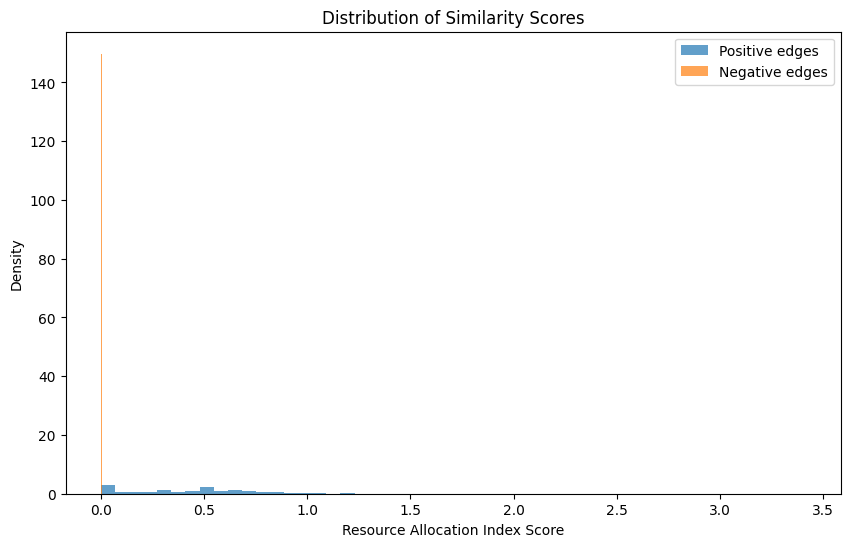

Average score for positive edges: 0.431199
Average score for negative edges: 0.000221
Standard deviation for positive edges: 0.309357
Standard deviation for negative edges: 0.007074


In [18]:
# Analyze the distribution of scores for positive vs negative examples
positive_scores = [probs[i] for i in range(len(probs)) if labels[i] == 1]
negative_scores = [probs[i] for i in range(len(probs)) if labels[i] == 0]

plt.figure(figsize=(10, 6))
plt.hist(positive_scores, bins=50, alpha=0.7, label='Positive edges', density=True)
plt.hist(negative_scores, bins=50, alpha=0.7, label='Negative edges', density=True)
plt.xlabel('Resource Allocation Index Score')
plt.ylabel('Density')
plt.title('Distribution of Similarity Scores')
plt.legend()
plt.show()

print(f"Average score for positive edges: {np.mean(positive_scores):.6f}") #this value reprsents the average similarity score for edges that actually exist in the network
print(f"Average score for negative edges: {np.mean(negative_scores):.6f}") #this value represents the average similarity score for edges that do not exist in the network
print(f"Standard deviation for positive edges: {np.std(positive_scores):.6f}")
print(f"Standard deviation for negative edges: {np.std(negative_scores):.6f}")

In [19]:
import numpy as np
import networkx as nx

# --- Common Neighbors ---
def common_neighbors_index(G, u, v):
    return len(set(G.neighbors(u)) & set(G.neighbors(v)))

# --- Salton Index ---
def salton_index(G, u, v):
    cn = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = np.sqrt(G.degree(u) * G.degree(v))
    return cn / denom if denom != 0 else 0

# --- Jaccard Coefficient ---
def jaccard_index(G, u, v):
    nu, nv = set(G.neighbors(u)), set(G.neighbors(v))
    inter = len(nu & nv)
    union = len(nu | nv)
    return inter / union if union != 0 else 0

# --- Sørensen Index ---
def sorensen_index(G, u, v):
    nu, nv = set(G.neighbors(u)), set(G.neighbors(v))
    inter = len(nu & nv)
    denom = len(nu) + len(nv)
    return 2 * inter / denom if denom != 0 else 0

# --- Hub Promoted Index (HPI) ---
def hub_promoted_index(G, u, v):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = min(G.degree(u), G.degree(v))
    return inter / denom if denom != 0 else 0

# --- Hub Depressed Index (HDI) ---
def hub_depressed_index(G, u, v):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = max(G.degree(u), G.degree(v))
    return inter / denom if denom != 0 else 0

# --- Leicht-Holme-Newman Index (LHN) ---
def leicht_holme_newman_index(G, u, v):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    denom = G.degree(u) * G.degree(v)
    return inter / denom if denom != 0 else 0

# --- Preferential Attachment ---
def preferential_attachment(G, u, v):
    return G.degree(u) * G.degree(v)

# --- Adamic-Adar Index ---
def adamic_adar_index(G, u, v):
    common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
    score = 0.0
    for z in common_neighbors:
        if G.degree(z) > 1:
            score += 1.0 / np.log(G.degree(z))
    return score

# --- Resource Allocation Index ---
def resource_allocation_index(G, u, v):
    common_neighbors = set(G.neighbors(u)) & set(G.neighbors(v))
    score = sum(1.0 / G.degree(z) for z in common_neighbors if G.degree(z) > 0)
    return score

# --- Local Path Index ---
def local_path_index(G, u, v, alpha=0.01):
    # A^3 is approximated by counting length-3 paths
    A = nx.to_numpy_array(G)
    A3 = np.linalg.matrix_power(A, 3)
    A2 = np.linalg.matrix_power(A, 2)
    cn = A2[G.nodes().index(u), G.nodes().index(v)]
    return cn + alpha * A3[G.nodes().index(u), G.nodes().index(v)]


In [20]:
Local_similarity_functions = {
    "CN": common_neighbors_index,
    "Salton": salton_index,
    "Jaccard": jaccard_index,
    "Sorensen": sorensen_index,
    "HPI": hub_promoted_index,
    "HDI": hub_depressed_index,
    "LHN": leicht_holme_newman_index,
    "PA": preferential_attachment,
    "AA": adamic_adar_index,
    "RA": resource_allocation_index
}

results = {}

for name, func in Local_similarity_functions.items():
    print(f"Starting k-fold cross-validation for {name}...")
    probs, labels = k_fold_link_prediction(G, k=5, similarity_func=func)
    fpr, tpr, roc_auc = evaluate_link_prediction(probs, labels)
    results[name] = roc_auc
    print(f"{name} AUC: {roc_auc:.4f}")

print("\nFinal AUC scores:")
for name, auc_val in results.items():
    print(f"{name}: {auc_val:.4f}")


Starting k-fold cross-validation for CN...
CN AUC: 0.9113
Starting k-fold cross-validation for Salton...
Salton AUC: 0.9117
Starting k-fold cross-validation for Jaccard...
Jaccard AUC: 0.9132
Starting k-fold cross-validation for Sorensen...
Sorensen AUC: 0.9145
Starting k-fold cross-validation for HPI...
HPI AUC: 0.9061
Starting k-fold cross-validation for HDI...
HDI AUC: 0.9101
Starting k-fold cross-validation for LHN...
LHN AUC: 0.9087
Starting k-fold cross-validation for PA...
PA AUC: 0.6763
Starting k-fold cross-validation for AA...
AA AUC: 0.9160
Starting k-fold cross-validation for RA...
RA AUC: 0.9079

Final AUC scores:
CN: 0.9113
Salton: 0.9117
Jaccard: 0.9132
Sorensen: 0.9145
HPI: 0.9061
HDI: 0.9101
LHN: 0.9087
PA: 0.6763
AA: 0.9160
RA: 0.9079


In [21]:
import numpy as np
import networkx as nx

#GLOBAL METRICS

# --- Katz Index ---
def katz_index(G, u, v, beta=0.005, max_iter=5):
    A = nx.to_numpy_array(G)
    n = A.shape[0]
    I = np.eye(n)
    M = np.linalg.inv(I - beta * A) - I
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    return M[i, j]

# --- Random Walk with Restart (RWR) ---
def rwr_index(G, u, v, c=0.85, tol=1e-6):
    nodes = list(G.nodes())
    n = len(nodes)
    idx = {node: i for i, node in enumerate(nodes)}
    A = nx.to_numpy_array(G)
    degs = A.sum(axis=1)
    P = np.divide(A, degs[:, None], out=np.zeros_like(A), where=degs[:, None]!=0)

    r = np.zeros(n)
    r[idx[u]] = 1.0
    prev = np.zeros(n)
    while np.linalg.norm(r - prev) > tol:
        prev = r.copy()
        r = (1 - c) * np.eye(n)[idx[u]] + c * P.T @ r
    return r[idx[v]]

# --- Shortest Path Similarity ---
def shortest_path_similarity(G, u, v):
    try:
        d = nx.shortest_path_length(G, u, v)
        return 1 / (d + 1)  # closer = higher similarity
    except nx.NetworkXNoPath:
        return 0.0

# --- LHNG (Leicht-Holme-Newman Global) ---
def lhng_index(G, u, v, gamma=0.5):
    inter = len(set(G.neighbors(u)) & set(G.neighbors(v)))
    du, dv = G.degree(u), G.degree(v)
    denom = (du * dv) ** gamma
    return inter / denom if denom != 0 else 0

# --- Average Commute Time (ACT) ---
def average_commute_time(G, u, v):
    L = nx.laplacian_matrix(G).toarray()
    L_pinv = np.linalg.pinv(L)
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    return L_pinv[i, i] + L_pinv[j, j] - 2 * L_pinv[i, j]

# --- Normalized ACT (NACT) ---
def normalized_act(G, u, v):
    act = average_commute_time(G, u, v)
    du, dv = G.degree(u), G.degree(v)
    return act / (du * dv) if du * dv > 0 else 0

# --- Cos+ Similarity ---
def cos_plus_similarity(G, u, v):
    A = nx.to_numpy_array(G)
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    vec_u, vec_v = A[i], A[j]
    num = np.dot(vec_u, vec_v)
    denom = np.linalg.norm(vec_u) * np.linalg.norm(vec_v)
    return num / denom if denom != 0 else 0

# --- Matrix Factorization Similarity (MF) ---
def matrix_factorization_similarity(G, u, v, rank=8):
    A = nx.to_numpy_array(G)
    U, S, Vt = np.linalg.svd(A, full_matrices=False)
    U_r = U[:, :rank] * np.sqrt(S[:rank])
    V_r = Vt[:rank, :].T * np.sqrt(S[:rank])
    nodes = list(G.nodes())
    i, j = nodes.index(u), nodes.index(v)
    return np.dot(U_r[i], V_r[j])

# --- Similarity Propagation Model (SPM) / SimRank-like ---
def spm_index(G, u, v, c=0.8, max_iter=5):
    A = nx.to_numpy_array(G)
    n = A.shape[0]
    nodes = list(G.nodes())
    deg = A.sum(axis=1)
    S = np.eye(n)
    for _ in range(max_iter):
        S_new = c * A.T @ (S / np.outer(deg, deg)) @ A
        np.fill_diagonal(S_new, 1)
        S = S_new
    i, j = nodes.index(u), nodes.index(v)
    return S[i, j]


In [ ]:

global_metric_similarity_functions = {
    "Katz": katz_index,
    "RWR": rwr_index,
    "ShortestPath": shortest_path_similarity,
    "LHNG": lhng_index,
    "ACT": average_commute_time,
    "NACT": normalized_act,
    "Cos+": cos_plus_similarity,
    "MF": matrix_factorization_similarity,
    "SPM": spm_index
}

results = {}

for name, func in global_metric_similarity_functions.items():
    print(f"Running k-fold link prediction for {name}...")
    probs, labels = k_fold_link_prediction(G, k=5, similarity_func=func)
    _, _, roc_auc = evaluate_link_prediction(probs, labels)
    results[name] = roc_auc
    print(f"{name}: {roc_auc:.4f}")

print("\n=== Final AUC Scores ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


Running k-fold link prediction for Katz...
Katz: 0.9208
Running k-fold link prediction for RWR...
RWR: 0.9208
Running k-fold link prediction for ShortestPath...
ShortestPath: 0.9140
Running k-fold link prediction for LHNG...
LHNG: 0.9149
Running k-fold link prediction for ACT...
ACT: 0.4086
Running k-fold link prediction for NACT...
NACT: 0.4374
Running k-fold link prediction for Cos+...
Cos+: 0.9085
Running k-fold link prediction for MF...
MF: 0.7201
Running k-fold link prediction for SPM...


/tmp/ipython-input-356237805.py:90: RuntimeWarning: divide by zero encountered in divide
  S_new = c * A.T @ (S / np.outer(deg, deg)) @ A
/tmp/ipython-input-356237805.py:90: RuntimeWarning: invalid value encountered in divide
  S_new = c * A.T @ (S / np.outer(deg, deg)) @ A
/tmp/ipython-input-356237805.py:90: RuntimeWarning: invalid value encountered in matmul
  S_new = c * A.T @ (S / np.outer(deg, deg)) @ A


In [ ]:
#QUASI-LOCAL METRICS
import numpy as np

def l3_index(G, u, v):
    """
    Compute L3 index between nodes u and v
    Reference: Kovács et al. (2019)
    """
    neighbors_u = set(G.neighbors(u))
    neighbors_v = set(G.neighbors(v))
    score = 0.0

    # Iterate over two intermediate nodes (i, j)
    for i in neighbors_u:
        for j in G.neighbors(i):
            if j in neighbors_v:
                score += 1.0 / np.sqrt(G.degree(i) * G.degree(j))
    return score

def local_path_index(G, u, v, epsilon=0.01):
    """
    Compute Local Path Index between nodes u and v
    Reference: Lü & Zhou (2009)
    """
    neighbors_u = set(G.neighbors(u))
    score = 0.0

    # CN term (paths of length 2)
    common_neighbors = neighbors_u & set(G.neighbors(v))
    score += len(common_neighbors)

    # Paths of length 3
    for x in neighbors_u:
        for y in G.neighbors(x):
            if y in G[v]:
                score += epsilon
    return score

In [ ]:
quasi_local_similarity_functions = {
    "L3": l3_index,
    "LocalPath": local_path_index
}
results =  {}

for name, func in quasi_local_similarity_functions.items():
    print(f"Running k-fold link prediction for {name}...")
    probs, labels = k_fold_link_prediction(G, k=5, similarity_func=func)
    _, _, roc_auc = evaluate_link_prediction(probs, labels)
    results[name] = roc_auc
    print(f"{name}: {roc_auc:.4f}")

print("\n=== Final AUC Scores ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")